In [1]:
!rm /content/sample_data/*
!rmdir /content/sample_data

In [2]:
# Everytime you will revisit the notebook after closing the session you have to upload the kaggle.json
# in case you restart the runtime you don't need to re-upload the kaggle .json
# nither the files that you have downloaded
from google.colab import files

files.upload() #prompt to upload kaggle.json
!mkdir /root/.kaggle #Creating a directory to store kaggle.json
!mv /content/kaggle.json /root/.kaggle/kaggle.json #moving kaggle.json to /root/.kaggle directory
!ls /root/.kaggle -a #Listing the content of the /root/.kaggle directory
!chmod 600 /root/.kaggle/kaggle.json #Changing property of file so that only i can see the key

Saving kaggle.json to kaggle.json
.  ..  kaggle.json


In [3]:
# CSV dataset
#!kaggle datasets download -d uciml/breast-cancer-wisconsin-data

# Image Dataset 6GB
#!kaggle datasets download -d skooch/ddsm-mammography

!kaggle datasets download -d kmader/mias-mammography
!unzip mias-mammography.zip
!rm mias-mammography.zip
#!tar -xf all-mias.tar.gz
!rm all-mias.tar.gz

 98% 305M/312M [00:03<00:00, 74.2MB/s]
100% 312M/312M [00:04<00:00, 80.9MB/s]
Archive:  mias-mammography.zip
  inflating: Info.txt                
  inflating: all-mias.tar.gz         
  inflating: all-mias/Info.txt       
  inflating: all-mias/Licence.txt    
  inflating: all-mias/README         
  inflating: all-mias/mdb001.pgm     
  inflating: all-mias/mdb002.pgm     
  inflating: all-mias/mdb003.pgm     
  inflating: all-mias/mdb004.pgm     
  inflating: all-mias/mdb005.pgm     
  inflating: all-mias/mdb006.pgm     
  inflating: all-mias/mdb007.pgm     
  inflating: all-mias/mdb008.pgm     
  inflating: all-mias/mdb009.pgm     
  inflating: all-mias/mdb010.pgm     
  inflating: all-mias/mdb011.pgm     
  inflating: all-mias/mdb012.pgm     
  inflating: all-mias/mdb013.pgm     
  inflating: all-mias/mdb014.pgm     
  inflating: all-mias/mdb015.pgm     
  inflating: all-mias/mdb016.pgm     
  inflating: all-mias/mdb017.pgm     
  inflating: all-mias/mdb018.pgm     
  inflating: all-

# Importing libraries

In [4]:
import re
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from skimage.transform import resize
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Labels

In [5]:
data = pd.read_csv("Info.txt", delimiter = ' ', usecols=['REFNUM', 'BG', 'CLASS', 'SEVERITY', 'X', 'Y', 'RADIUS'])
data.shape

(330, 7)

In [6]:
print(data)

     REFNUM BG CLASS SEVERITY      X      Y  RADIUS
0    mdb001  G  CIRC        B  535.0  425.0   197.0
1    mdb002  G  CIRC        B  522.0  280.0    69.0
2    mdb003  D  NORM      NaN    NaN    NaN     NaN
3    mdb004  D  NORM      NaN    NaN    NaN     NaN
4    mdb005  F  CIRC        B  477.0  133.0    30.0
..      ... ..   ...      ...    ...    ...     ...
325  mdb318  D  NORM      NaN    NaN    NaN     NaN
326  mdb319  D  NORM      NaN    NaN    NaN     NaN
327  mdb320  D  NORM      NaN    NaN    NaN     NaN
328  mdb321  D  NORM      NaN    NaN    NaN     NaN
329  mdb322  D  NORM      NaN    NaN    NaN     NaN

[330 rows x 7 columns]


Adding 20 values with misssing radius values

In [7]:
cancer_classes = ['CALC', 'CIRC', 'ARCH', 'SPIC', 'MISC', 'ASYM']
min_X_not_null = int(min(data[data['X'].notnull()]['X']))
max_X_not_null = int(max(data[data['X'].notnull()]['X']))
min_Y_not_null = int(min(data[data['Y'].notnull()]['Y']))
max_Y_not_null = int(max(data[data['Y'].notnull()]['Y']))
print(min_X_not_null, max_X_not_null, min_Y_not_null, max_Y_not_null)
# Generating 20 random X, Y values for random cancer classes
from random import sample
rows = []
for i in range(20):
    rows.append([
        f'mdb{323+i}',
        sample(['G','D','F'], 1),
        sample(cancer_classes, 1),
        sample(['B', 'M'], 1),
        sample(range(min_X_not_null, max_X_not_null+1), 1),
        sample(range(min_Y_not_null, max_Y_not_null+1), 1),
        np.nan
    ])
new_values_data = pd.DataFrame(rows, columns=['REFNUM', 'BG', 'CLASS', 'SEVERITY', 'X', 'Y', 'RADIUS'])
# Inserting new 20 new rows with NaN Radius values
data = data.append(new_values_data)
print(data.shape)

127 793 125 994
(350, 7)


Filling the missiing values with mean


In [33]:
print(data[data['RADIUS'].notnull()])
mean_of_radius = data[data['RADIUS'].notnull()]['RADIUS'].mean()
for index, row in data.iterrows():
  if row['CLASS'] != 'NORM':
    data.at[i,'RADIUS'] = mean_of_radius
print(data)
print(data[data['RADIUS'].notnull()])

     REFNUM   BG   CLASS SEVERITY      X      Y      RADIUS
0    mdb001    G    CIRC        B    535    425  197.000000
1    mdb002    G    CIRC        B    522    280   69.000000
4    mdb005    F    CIRC        B    477    133   30.000000
5    mdb005    F    CIRC        B    500    168   26.000000
10   mdb010    F    CIRC        B    525    425   33.000000
..      ...  ...     ...      ...    ...    ...         ...
297  mdb290    D    CIRC        B    337    353   45.000000
319  mdb312    F    MISC        B    240    263   20.000000
321  mdb314    F    MISC        B    518    191   39.000000
322  mdb315    D    CIRC        B    516    447   93.000000
19   mdb342  [F]  [ASYM]      [B]  [238]  [267]   48.847458

[120 rows x 7 columns]
    REFNUM   BG   CLASS SEVERITY      X      Y      RADIUS
0   mdb001    G    CIRC        B    535    425  197.000000
1   mdb002    G    CIRC        B    522    280   69.000000
2   mdb003    D    NORM      NaN    NaN    NaN         NaN
3   mdb004    D    N

In [ ]:
data.CLASS.value_counts()

NORM    207
CALC     30
CIRC     25
ARCH     19
SPIC     19
MISC     15
ASYM     15
Name: CLASS, dtype: int64

In [ ]:
def createY(class_label):
  if class_label == 'NORM':
    return np.array([1, 0, 0, 0, 0, 0, 0])
  elif class_label == 'CALC':
    return np.array([0, 1, 0, 0, 0, 0, 0])
  elif class_label == 'CIRC':
    return np.array([0, 0, 1, 0, 0, 0, 0])
  elif class_label == 'ARCH':
    return np.array([0, 0, 0, 1, 0, 0, 0])
  elif class_label == 'SPIC':
    return np.array([0, 0, 0, 0, 1, 0, 0])
  elif class_label == 'MISC':
    return np.array([0, 0, 0, 0, 0, 1, 0])
  elif class_label == 'ASYM':
    return np.array([0, 0, 0, 0, 0, 0, 1])

In [ ]:
labels = []
for class_value in data.CLASS:
  labels.append(createY(class_value))
labels = np.array(labels)
labels.shape

(330, 7)

In [ ]:
labels.ndim

2

# Images

In [ ]:
# code fromm "https://blog.jacob.vi/modifying-tensorflows-mnist-for-beginners-tutorial-to-search-for-cancer-in-mammograms/"
def OpenPGM(filename):
  with open(filename, 'rb') as f:
    buffer = f.read()
  try:
    header, width, height, maxval = re.search(
    b"(^P5\s(?:\s*#.*[\r\n])*"
    b"(\d+)\s(?:\s*#.*[\r\n])*"
    b"(\d+)\s(?:\s*#.*[\r\n])*"
    b"(\d+)\s(?:\s*#.*[\r\n]\s)*)", buffer).groups()
  except AttributeError:
    raise ValueError("Not a raw PGM file: '%s'" % filename)
  return np.frombuffer(buffer,
                          dtype='u1' if int(maxval) < 256 else byteorder+'u2',
                          count=int(width)*int(height),
                          offset=len(header)).reshape((int(height),int(width)))

In [ ]:
import cv2
directory = "/content/all-mias/"

images = []
for filename in data.REFNUM:
  images.append(cv2.resize(np.stack((OpenPGM(directory+filename+'.pgm'), )*3, axis = -1), dsize = (224, 224), interpolation = cv2.INTER_CUBIC))

images = np.array(images)
print(images.shape, images.ndim, sep = '\n')

(330, 224, 224, 3)
4


In [ ]:
generator = ImageDataGenerator(rescale=1./255., horizontal_flip = True, validation_split=0.2)

training_data = generator.flow(images, labels, batch_size = 16, subset = 'training', shuffle = True)
validation_data = generator.flow(images, labels, batch_size = 16, subset = 'validation', shuffle = True)

In [ ]:
sample_images, sample_labels = next(training_data)

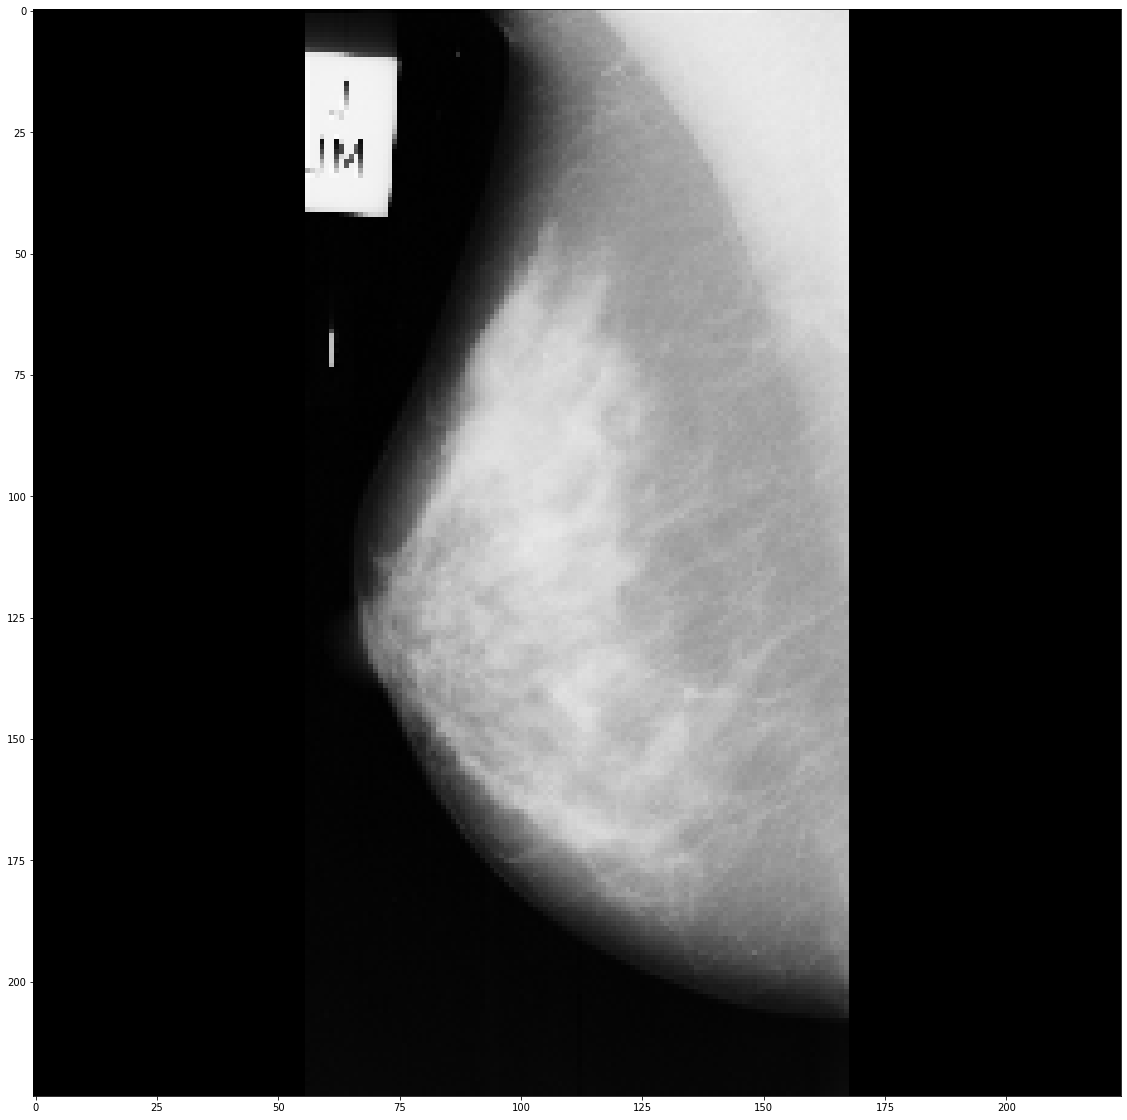

In [ ]:
plt.figure(figsize = (20, 20))
plt.imshow(sample_images[0])

# Creating Model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Conv2D, GlobalAveragePooling2D, Flatten, Dense, Dropout

In [ ]:
image_shape = (224, 224, 3)
base_model = VGG16(input_shape = image_shape, include_top = False, weights = 'imagenet')

58892288/58889256 [==============================] - 0s 0us/step


In [ ]:
base_model.trainable = False

In [ ]:
model = Sequential([
                    base_model,
                    GlobalAveragePooling2D(),
                    Dense(512, activation = 'relu'),
                    # Dropout(0.4),
                    # Dense(256, activation = 'relu'),
                    # Dropout(0.4),
                    Dense(128, activation = 'relu'),
                    # Dropout(0.4),
                    Dense(64, activation = 'relu'),
                    # Dropout(0.4),
                    Dense(7, activation = 'softmax')
])

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001)
model.compile(optimizer = optimizer, loss = "CategoricalCrossentropy", metrics = ['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 512)               262656    
_________________________________________________________________
dense_1 (Dense)              (None, 128)               65664     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 7)                 455       
Total params: 15,051,719
Trainable params: 337,031
Non-trainable params: 14,714,688
______________________________________

In [ ]:
history = model.fit(training_data, epochs = 300, validation_data = validation_data, )

Epoch 1/300
17/17 [==============================] - 2s 130ms/step - loss: 1.7322 - accuracy: 0.4318 - val_loss: 1.4133 - val_accuracy: 0.7121
Epoch 2/300
17/17 [==============================] - 1s 71ms/step - loss: 1.4334 - accuracy: 0.6061 - val_loss: 1.2287 - val_accuracy: 0.7121
Epoch 3/300
17/17 [==============================] - 1s 70ms/step - loss: 1.3602 - accuracy: 0.6061 - val_loss: 1.2003 - val_accuracy: 0.7121
Epoch 4/300
17/17 [==============================] - 1s 71ms/step - loss: 1.3622 - accuracy: 0.6061 - val_loss: 1.2073 - val_accuracy: 0.7121
Epoch 5/300
17/17 [==============================] - 1s 71ms/step - loss: 1.3572 - accuracy: 0.6061 - val_loss: 1.2557 - val_accuracy: 0.7121
Epoch 6/300
17/17 [==============================] - 1s 70ms/step - loss: 1.3504 - accuracy: 0.6061 - val_loss: 1.2440 - val_accuracy: 0.7121
Epoch 7/300
17/17 [==============================] - 1s 70ms/step - loss: 1.3517 - accuracy: 0.6061 - val_loss: 1.2493 - val_accuracy: 0.7121
Epoch

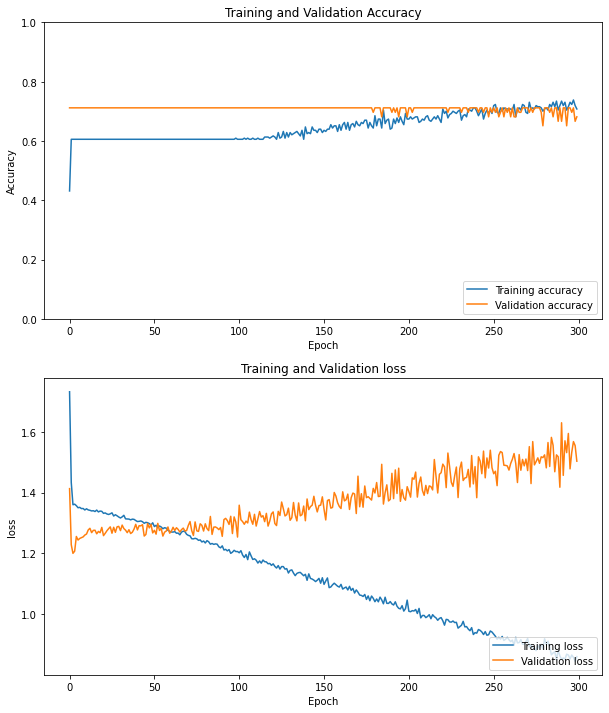

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.figure(figsize=(10,12))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training accuracy')
plt.plot(val_acc, label='Validation accuracy')
plt.legend(loc='lower right')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0,1])
plt.title("Training and Validation Accuracy")

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training loss')
plt.plot(val_loss, label='Validation loss')
plt.legend(loc='lower right')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.title("Training and Validation loss")
plt.show()

In [ ]:
model.save("test2.h5")